# Flight Performance Analysis for an RV-8 Aircraft

## Required Software

* [Anaconda Python Distribution](https://www.continuum.io/downloads), includes NumPy, Pandas, SciPy, Matplotlib, etc.
* [Jupyter Notebook](http://jupyter.org/), to display and edit this document, included with Anaconda.
* [Seaborn Data Visualization](http://seaborn.pydata.org/), for plotting aesthetics.
* [Scikit-Aero Python package](https://github.com/AeroPython/scikit-aero), for standard atmosphere calculations [v.0.2-dev].

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skaero.atmosphere import coesa as atm

In [25]:
# Seaborn plot style
%matplotlib inline
sns.set_context("talk", font_scale=1.8, rc={"lines.linewidth": 6, "figure.figsize":(20,12)})

## Van's Aircraft RV-8 Specifications
Ref: https://www.vansaircraft.com/public/rv8specs.htm

In [26]:
# Wing span (ft)
b = 24

# Wing area (sq ft) 
S = 116

# Wing chord (constant, no taper)
c = S/b

# Aspect ratio
AR = b**2/S

# Gross weight (lbs)
W = 1800

# Wing loading (lb/sq ft)
WL = W/S

# Fuel capacity (US gal)
fuel_capacity = 42

# Engine rated power (hp)
W_dot = 180

## Zero-Lift Drag and Oswald Efficiency
Initially, we cheat a bit here, using data derived by Kevin Horton in his [AeroCalc](https://github.com/khorton/AeroCalc_Package/blob/master/aerocalc/personal/ft_data_reduction.py) Python package.

In [28]:
# Oswald efficiency factor estimation, ref: D. Raymer [2], Eqn. (12.49), p. 347.
e = 1.78 * (1 - 0.045 * AR**0.68) - 0.64

# Oswald efficiency factor estimation, ref.: K. Horton
e = 0.86

# Parasite drag coefficient, zero-lift (ref.: K. Horton)
C_d_0 = 0.0209

## Free Stream Velocity
A range of likely velocity values for a light aircraft, from about 60 to 220 KTAS (knots true airspeed).

In [29]:
# Free stream velocity (ft/s)
V = np.arange(100,370)

## Drag Polar

## U.S. Standard Atmosphere

The `scikit-aero` COESA algorithm is based on the [1976 U.S. Standard Atmosphere](http://ntrs.nasa.gov/search.jsp?R=19770009539).  The previous 1962 U.S. Standard Atmosphere is the standard used by the FAA and the flight test community for aircraft performance assessments, however the updated 1976 version differs from this only above 32 km [[1](#ref)].

Compare computed results here with an online [Standard Atmosphere Calculator](https://www.digitaldutch.com/atmoscalc/).

In [30]:
# COESA 1976 U.S. Standard Atmosphere (SI units!)

# Altitude to test (ft)
altitude = 23000

# Air density (kg/m^3)
rho = atm.density(altitude * 0.3048)

# Air density (slugs/ft^3)
rho = rho * 0.00194032

# Compare computed results with: https://www.digitaldutch.com/atmoscalc/
print("Air density at {:,.0f} ft = {:,.6f} slugs/ft^3".format(altitude, rho))

Air density at 23,000 ft = 0.001142 slugs/ft^3


## Thrust Required for Level Flight

Equations from Anderson [3].

\begin{equation} \tag{6.13}
  T = D = q_{\infty} S C_D
\end{equation}

\begin{equation} \tag{6.14}
  L = W = q_{\infty} S C_D
\end{equation}

\begin{equation} \tag{6.15}
  \frac{T}{W} = \frac{C_D}{C_L}
\end{equation}

\begin{equation} \tag{6.16}
  T_R = \frac{W}{C_L/C_D}
\end{equation}

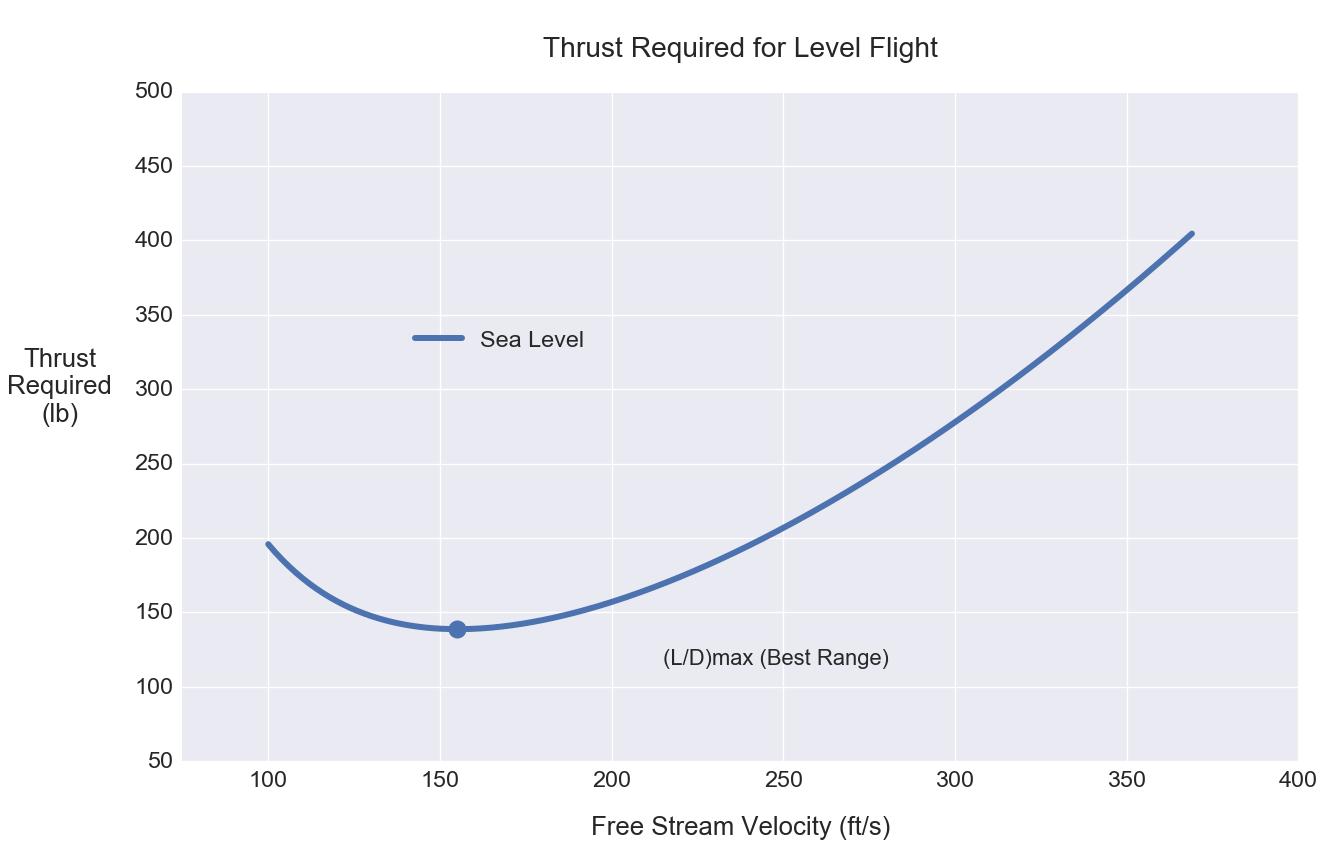

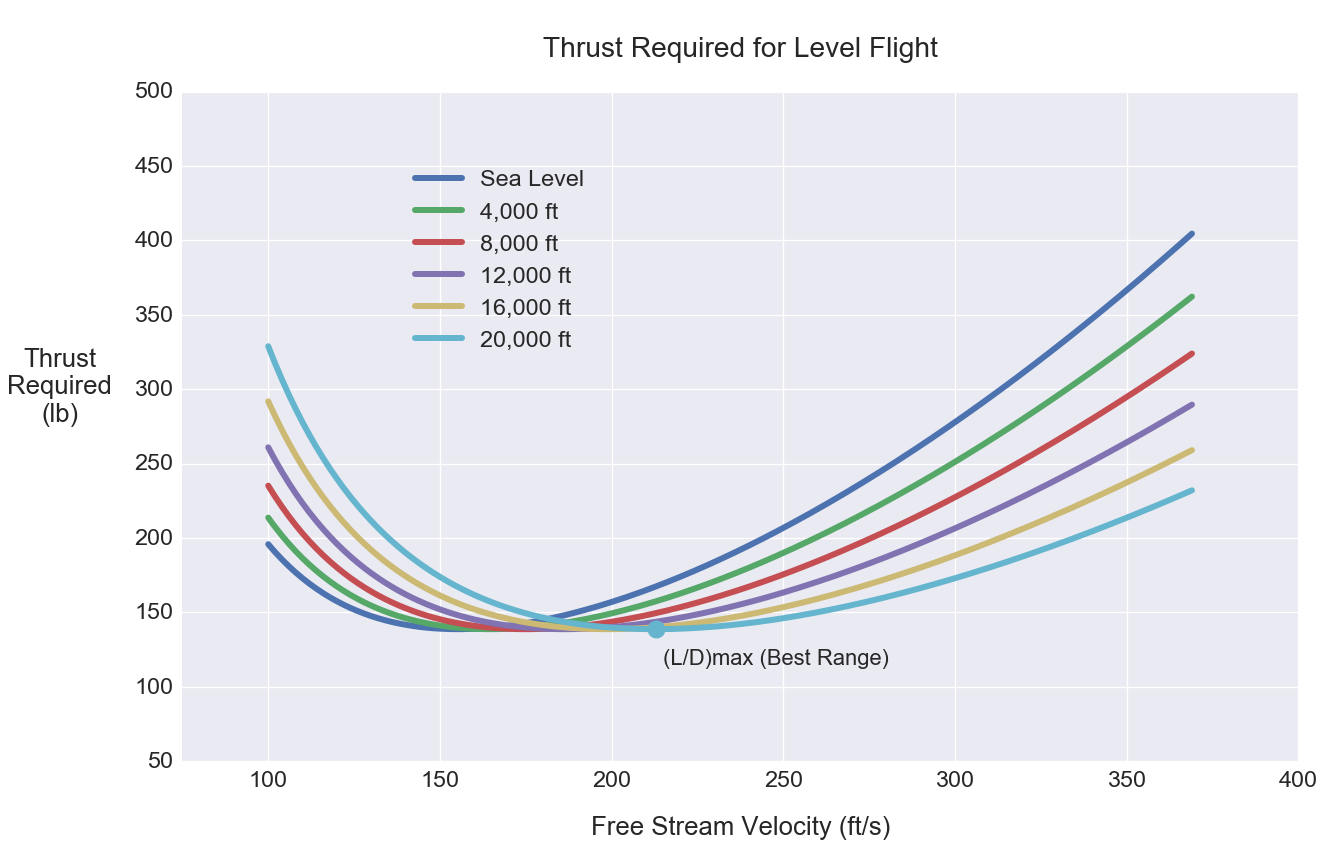

In [31]:
def plot_thrust_required(V, Max_Alt=0, min_color="#4c72b0"):
    """
    Plot thrust required curves for altitudes from sea level to Max_Alt in 4,000-ft increments.
    
    Keyword arguments:
    V -- a 1D array of velocity values in ft/s
    Max_Alt -- an altitude, in feet, at which to stop plotting curves (default 0, sea level)
    min_color -- a hex color code for the min value marker
    """
    legend = ['Sea Level']
    for altitude in range(0, Max_Alt + 1, 4000):
        
        # COESA 1976 U.S. Standard Atmosphere (SI units!)
        # Air density (kg/m^3)
        rho = atm.density(altitude * 0.3048)
        
        # Air density (slugs/ft^3)
        rho = rho * 0.00194032
        
        # Lift coefficient
        CL = W / (0.5 * rho * V**2 * S)
        
        # Drag coefficient
        CD = C_d_0 + CL**2 / (np.pi * e * AR)
        
        # Thrust required (lbs)
        Tr = W / (CL / CD)
        
        # Add a curve
        plt.plot(V,Tr)
        
        # Update the legend
        if altitude > 0:
            legend.append("{:,.0f} ft".format(altitude))
 
    # Locate the axis labels and limits
    ax = plt.gca()
    ax.set_xlim([75,400])
    ax.set_ylim([50,500])
    ax.xaxis.set_label_coords(0.5, -0.08)
    ax.yaxis.set_label_coords(-0.11, 0.5)
    ax.text(215, 115, '(L/D)max (Best Range)', size=22)
    
    # Add title and axis labels
    plt.legend(legend,loc=(0.2, 0.6))
    plt.title("\n Thrust Required for Level Flight \n")
    plt.ylabel('Thrust\nRequired\n(lb)', rotation=0)
    plt.xlabel('Free Stream Velocity (ft/s)')
    
    # Plot (L/D)max point
    plt.plot(V[np.argmin(Tr)], np.amin(Tr), marker='o', ms=18, color=min_color)
    plt.show()

plot_thrust_required(V,0)
plot_thrust_required(V,20000,"#64b5cd")

## Power Required for Level Flight

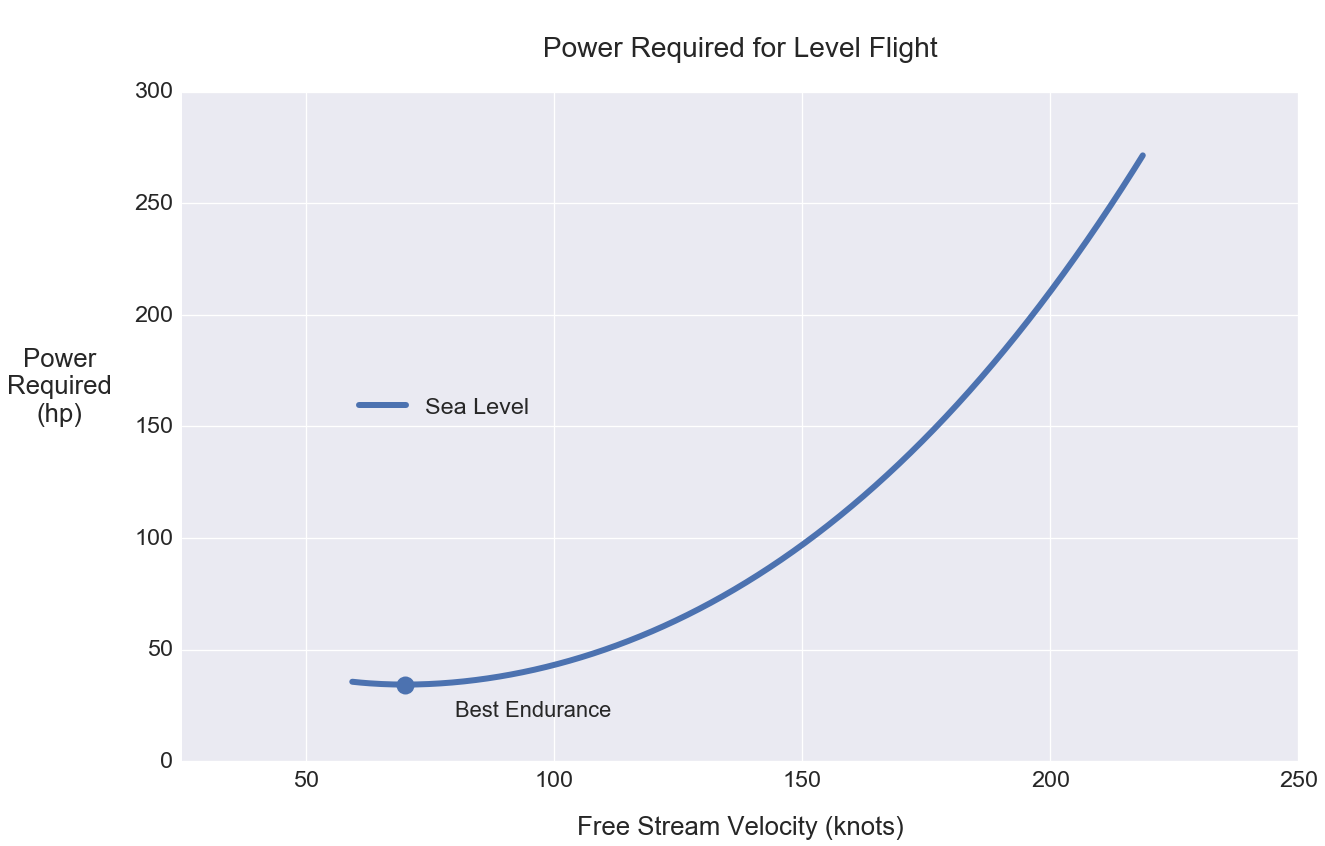

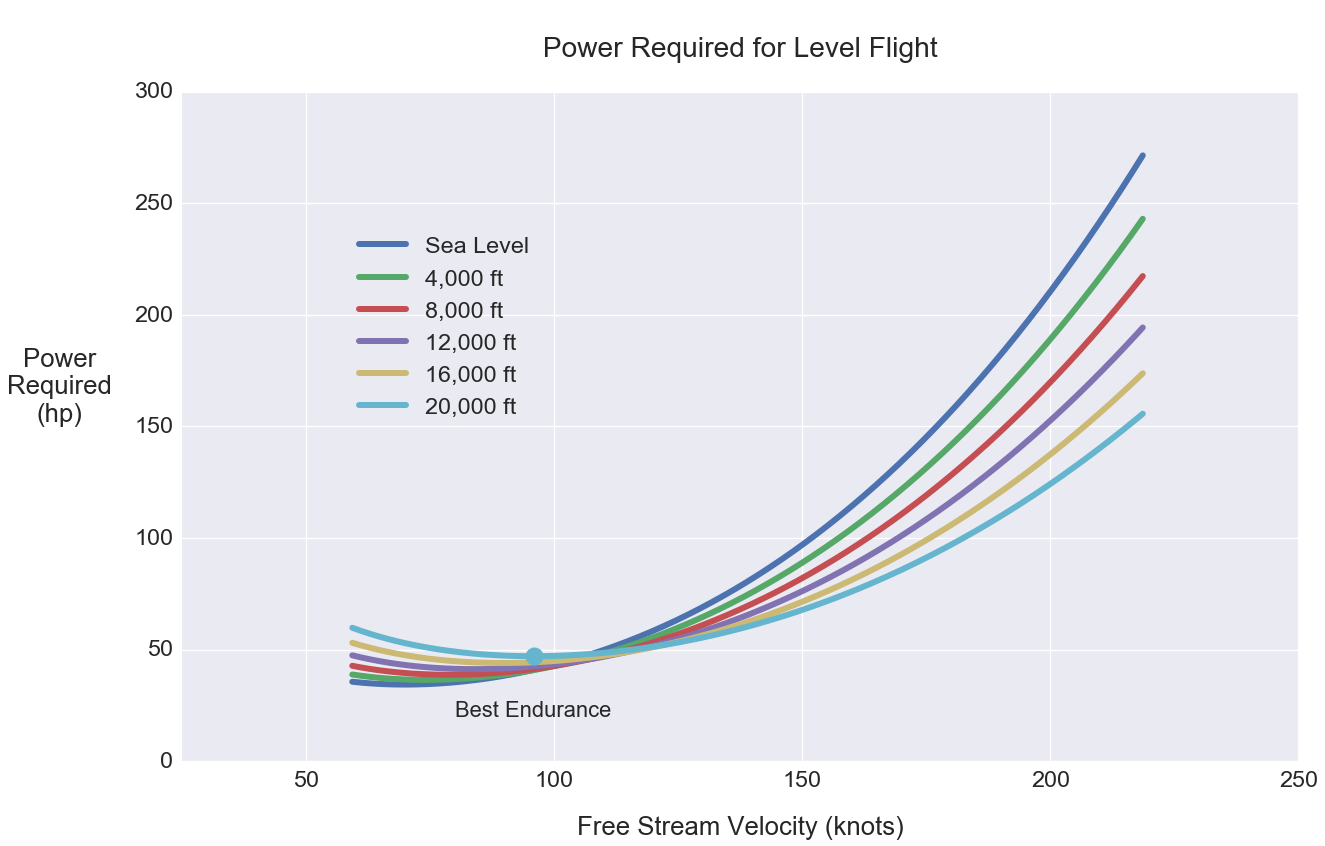

In [32]:
def plot_power_required(V, Max_Alt=0, min_color="#4c72b0"):
    """
    Plot power required curves for altitudes from sea level to Max_Alt in 4,000-ft increments.
    
    Keyword arguments:
    V -- a 1D array of velocity values in ft/s
    Max_Alt -- an altitude, in feet, at which to stop plotting curves (default 0, sea level)
    min_color -- a hex color code for the min value marker
    """
    legend = ['Sea Level']
    for altitude in range(0, Max_Alt + 1, 4000):
        
        # COESA 1976 U.S. Standard Atmosphere (SI units!)
        # Air density (kg/m^3)
        rho = atm.density(altitude * 0.3048)
        
        # Air density (slugs/ft^3)
        rho = rho * 0.00194032
        
        # Lift coefficient
        CL = W / (0.5 * rho * V**2 * S)
        
        # Drag coefficient
        CD = C_d_0 + CL**2 / (np.pi * e * AR)
        
        # Thrust required (lbs)
        Tr = W / (CL / CD)
        
        # Power required (hp)
        Pr = (Tr * V) / 550
        
        # Add a curve (1 ft/s = 0.592484 knots)
        plt.plot(V*0.592484,Pr)
        
        # Update the legend
        if altitude > 0:
            legend.append("{:,.0f} ft".format(altitude))
 
    # Locate the axis labels and limits
    ax = plt.gca()
    ax.set_xlim([25,250])
    ax.set_ylim([0,300])
    ax.xaxis.set_label_coords(0.5, -0.08)
    ax.yaxis.set_label_coords(-0.11, 0.5)
    ax.text(80, 20, 'Best Endurance', size=22)
    
    # Add title and axis labels
    plt.legend(legend,loc=(0.15, 0.50))
    plt.title("\n Power Required for Level Flight \n")
    plt.ylabel('Power\nRequired\n(hp)', rotation=0)
    plt.xlabel('Free Stream Velocity (knots)')
    
    # Plot (L/D)max point
    plt.plot(V[np.argmin(Pr)]*0.592484, np.amin(Pr), marker='o', ms=18, color=min_color)
    plt.show()

plot_power_required(V,0)
plot_power_required(V,20000,"#64b5cd")

<h2 id="ref">References</h2>

[ 1 ]  R. D. Kimberlin, _Flight Testing of Fixed-Wing Aircraft_. Reston, Virginia: AIAA, 2003.

[ 2 ] D. P. Raymer, _Aircraft Design: A Conceptual Approach_. Reston, Virginia: AIAA, 4th ed., 2006.

[ 3 ] J. D. Anderson, _Introduction to Flight_. NY, New York: McGraw-Hill, 5th ed., 2005.

[ 4 ] J. D. Mattingly and K. M. Boyer, _Elements of Propulsion: Gas Turbines and Rockets_. Reston, Virginia: AIAA, 2nd ed., 2016.

In [33]:
e

0.9018292785843448